# Stock Prediction

suggesting stocks which would go up tmrw using LightGBM.

suggesting from 300 tickers and collected the financial data from yfinance. In previous version, I tried to predict daily return for each, however, there are a lot of factors that affect the daily return. So instead of predicting daily return, I predict which stocks will go up. When tuning model, the score is focused on this prediction.

I added feature engineering, technical operators. However, I decided not to use most of them because they reduce score. In order to take care of time series, added lags for some columns.

Collected 10 years period, 1 day interval for each stock and split into train, validation and test data. In stock prediction, we should not use future data to train model. so I used first 70% as a train, 18% as a validation, and 12% as a test data.

Used LightGBM model because the executing time is much smaller then Random Forest or XGBOOST. When tuning, used TimeSeriesSplit for cross validation, and the maximizing score is the average daily return of the few biggest daily return.



In [2]:
import chart_studio.plotly as py
import math
import matplotlib
import numpy as np
import os
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import pylab
from plotly.offline import iplot
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as pyo
import scipy.stats as stats
import time
import yfinance as yf
import talib

from collections import defaultdict
from datetime import date
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from pylab import rcParams
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
import xgboost
import lightgbm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import TimeSeriesSplit

from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from tqdm.notebook import tqdm_notebook

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

%matplotlib inline

In [3]:
need_row_data = False
load_data = False

seed = 42

period = '6y'
interval = '1d'
start = '2016-07-08'
end = '2022-07-09'

day_after = 1

N = 10

train_size = 0.8          # split data into train, validation, and test with ratio of 0.7, 0.15, 0.15
val_size = 0.5

# Load data

In [4]:
if need_row_data:
    csvs = [
        '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'
    ]

    tickers = pd.DataFrame()
    for csv in csvs:
        data = pd.read_csv(f'data/row_jap/{csv}.csv')
        tickers = pd.concat([tickers, data], axis=0)

    #with open('models/row_jap_stock.pickle', 'wb') as handle:
    #    pickle.dump(tickers, handle, protocol=pickle.HIGHEST_PROTOCOL)

    tickers = tickers[['ｺｰﾄﾞ', '会社名', '業種', '時価総額\r\n(10億円)']]
    tickers.rename(columns={"ｺｰﾄﾞ": "ticker", "会社名": "company", "業種":"sector", "時価総額\r\n(10億円)": "market_cap"}, inplace=True)
    tickers.replace(',','', regex=True, inplace=True)
    tickers['market_cap'] = tickers['market_cap'].astype(str).astype(int)

    with open('data/jap_ticker.pickle', 'wb') as handle:
        pickle.dump(tickers, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('data/jap_ticker.pickle', 'rb') as handle:
        tickers = pickle.load(handle)

tickers.head()

,ticker,company,sector,market_cap
0,7203,トヨタ自動車,自動車・自動車部品,33576
1,1306,ＮＥＸＴ ＦＵＮＤＳ ＴＯＰＩＸ連動型上,その他金融,15764
2,9432,日本電信電話,通信,13858
3,6758,ソニーグループ,電気機器,13658
4,6861,キーエンス,電気機器,11667


In [5]:
if load_data:
    dfs = []

    forex_data = yf.download('USDJPY=X', start=start, end=end, interval=interval, progress=False)
    forex_data.rename({"Adj Close": 'forex'}, inplace=True, axis=1)
    forex = forex_data[['forex']]

    dji_data = yf.download('^dji', start=start, end=end, interval=interval, progress=False)
    dji_data.rename({"Adj Close": 'dji'}, inplace=True, axis=1)
    dji = dji_data[['dji']]#.shift(1)

    sp500_data = yf.download(tickers='^GSPC', start=start, end=end, interval=interval, progress=False)
    sp500_data.rename({"Adj Close": 'sp500'}, inplace=True, axis=1)
    sp500 = sp500_data[['sp500']]

    n225_data = yf.download(tickers='^N225', start=start, end=end, interval=interval, progress=False)
    n225_data.rename({"Adj Close": 'n225'}, inplace=True, axis=1)
    n225 = n225_data[['n225']].shift(1)

    bond13_data = yf.download(tickers='^IRX', start=start, end=end, interval=interval, progress=False)
    bond13_data.rename({"Adj Close": 'bond13'}, inplace=True, axis=1)
    bond13 = bond13_data[['bond13']]

    bond5_data = yf.download(tickers='^FVX', start=start, end=end, interval=interval, progress=False)
    bond5_data.rename({"Adj Close": 'bond5'}, inplace=True, axis=1)
    bond5 = bond5_data[['bond5']]

    for i, company in tqdm_notebook(tickers.iterrows(), total=len(tickers)):
        ticker = str(company["ticker"]) + '.T'
        try:
            temp_df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
            # create ticker column and sector column
            temp_df = pd.concat([temp_df, forex, dji, n225, sp500, bond13, bond5], axis=1, join='inner')
            temp_df['ticker'] = ticker
            temp_df['sector'] = company["sector"]

            dfs.append(temp_df)
        except Exception as e: print(e)

else:
    with open('data/jp_company_data_2022_7_7.pickle', 'rb') as handle:
        dfs = pickle.load(handle)

dfs[0].tail()

,Open,High,Low,Close,Adj Close,Volume,forex,dji,n225,sp500,bond13,bond5,ticker,sector
Date,,,,,,,,,,,,,,
2022-07-01,2095.0,2104.0,2056.0,2067.0,2067.0,30994400,135.785995,31097.259766,26393.039062,3825.330078,1.603,2.884,7203.T,自動車・自動車部品
2022-07-05,2128.0,2136.0,2112.0,2116.5,2116.5,20328900,135.839996,30967.820312,26153.810547,3831.389893,1.630,2.815,7203.T,自動車・自動車部品
2022-07-06,2089.0,2098.0,2043.5,2058.0,2058.0,32025100,135.520996,31037.679688,26423.470703,3845.080078,1.840,2.951,7203.T,自動車・自動車部品
2022-07-07,2086.5,2108.0,2065.0,2105.0,2105.0,27506300,135.966003,31384.550781,26107.650391,3902.620117,1.853,3.054,7203.T,自動車・自動車部品
2022-07-08,2120.5,2147.0,2108.0,2111.0,2111.0,35446600,135.912994,31338.150391,26490.529297,3899.379883,1.843,3.142,7203.T,自動車・自動車部品


In [6]:
dfs[0].head()

,Open,High,Low,Close,Adj Close,Volume,forex,dji,n225,sp500,bond13,bond5,ticker,sector
Date,,,,,,,,,,,,,,
2016-07-08,1019.000000,1031.400024,1011.000000,1011.000000,784.024963,52315500,100.790001,18146.740234,NaN,2129.899902,0.273,0.952,7203.T,自動車・自動車部品
2016-07-11,1011.000000,1011.000000,1011.000000,1011.000000,784.024963,0,100.692001,18226.929688,15106.980469,2137.159912,0.275,1.025,7203.T,自動車・自動車部品
2016-07-12,1082.800049,1105.000000,1082.000000,1088.599976,844.203247,71689000,102.524002,18347.669922,15708.820312,2152.139893,0.295,1.083,7203.T,自動車・自動車部品
2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896484,97297000,104.755997,18372.119141,16095.650391,2152.429932,0.298,1.055,7203.T,自動車・自動車部品
2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998657,57826000,104.075996,18506.410156,16231.429688,2163.750000,0.303,1.091,7203.T,自動車・自動車部品


In [7]:
#with open('data/jp_company_data_2022_7_7.pickle', 'wb') as handle:
#    pickle.dump(dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
for df in dfs:
    df.drop(columns=['forex', 'dji', 'n225', 'sp500', 'bond13', 'bond5'], inplace=True)

In [9]:
remove_df_i = []

for i, temp_df in enumerate(dfs):
    if temp_df.shape[0] == 0:
        print(temp_df.ticker)
        remove_df_i.append(i)
        continue
    temp_df.reset_index(inplace=True)
    # Change all column headings to be lower case, and remove spacing
    temp_df.columns = [str(x).lower().replace(' ', '_') for x in temp_df.columns]

    # Sort by datetime
    temp_df.sort_values(by='date', inplace=True, ascending=True)

    # Create returns column
    temp_df['daily_ret'] = 100.0 * ((temp_df['adj_close'].shift(-1*day_after) / temp_df['adj_close'])-1)
    temp_df['volatility'] = (temp_df['high'] - temp_df['low'])/temp_df['high']
    #temp_df['dji_ret'] = 100.0 * ((temp_df['dji'].shift(1) / temp_df['dji'])-1)*-1
    #temp_df['forex_ret'] = 100.0 * ((temp_df['forex'].shift(1) / temp_df['forex'])-1)*-1
    #temp_df['sp500_ret'] = 100.0 * ((temp_df['sp500'].shift(1) / temp_df['sp500'])-1)*-1
    #temp_df['n225_ret'] = 100.0 * ((temp_df['n225'].shift(1) / temp_df['n225'])-1)*-1
    #temp_df['bond13_ret'] = 100.0 * ((temp_df['bond13'].shift(1) / temp_df['bond13'])-1)*-1
    #temp_df['bond5_ret'] = 100.0 * ((temp_df['bond5'].shift(1) / temp_df['bond5'])-1)*-1

    # create weekday column
    date = pd.to_datetime(temp_df['date']).dt
    temp_df['weekday'] = date.weekday
    temp_df['month'] = date.month

for index in sorted(remove_df_i, reverse=True):
    del dfs[index]

dfs[0].tail()

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,volatility,weekday,month
1407,2022-07-01,2095.0,2104.0,2056.0,2067.0,2067.0,30994400,7203.T,自動車・自動車部品,2.394775,0.022814,4,7
1408,2022-07-05,2128.0,2136.0,2112.0,2116.5,2116.5,20328900,7203.T,自動車・自動車部品,-2.763997,0.011236,1,7
1409,2022-07-06,2089.0,2098.0,2043.5,2058.0,2058.0,32025100,7203.T,自動車・自動車部品,2.283771,0.025977,2,7
1410,2022-07-07,2086.5,2108.0,2065.0,2105.0,2105.0,27506300,7203.T,自動車・自動車部品,0.285036,0.020398,3,7
1411,2022-07-08,2120.5,2147.0,2108.0,2111.0,2111.0,35446600,7203.T,自動車・自動車部品,NaN,0.018165,4,7


In [10]:
count = 0
for df in dfs:
    if df.iloc[-1]['close'] > 12000:
        count += 1
print(count)

40


In [11]:
dfs

[           date         open         high          low        close  \
 0    2016-07-08  1019.000000  1031.400024  1011.000000  1011.000000   
 1    2016-07-11  1011.000000  1011.000000  1011.000000  1011.000000   
 2    2016-07-12  1082.800049  1105.000000  1082.000000  1088.599976   
 3    2016-07-13  1113.199951  1128.599976  1103.000000  1125.599976   
 4    2016-07-14  1115.599976  1132.000000  1114.199951  1129.599976   
 ...         ...          ...          ...          ...          ...   
 1407 2022-07-01  2095.000000  2104.000000  2056.000000  2067.000000   
 1408 2022-07-05  2128.000000  2136.000000  2112.000000  2116.500000   
 1409 2022-07-06  2089.000000  2098.000000  2043.500000  2058.000000   
 1410 2022-07-07  2086.500000  2108.000000  2065.000000  2105.000000   
 1411 2022-07-08  2120.500000  2147.000000  2108.000000  2111.000000   
 
         adj_close    volume  ticker     sector  daily_ret  volatility  \
 0      784.024963  52315500  7203.T  自動車・自動車部品   0.000000  

# Feature Engineering

In [12]:
dfs[0][195:200]

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,volatility,weekday,month
195,2017-05-09,1247.000000,1248.400024,1224.400024,1227.000000,985.047241,37815000,7203.T,自動車・自動車部品,-0.880202,0.019225,1,5
196,2017-05-10,1232.400024,1234.199951,1216.199951,1216.199951,976.376831,39118500,7203.T,自動車・自動車部品,0.690688,0.014584,2,5
197,2017-05-11,1222.599976,1224.800049,1195.000000,1224.599976,983.120544,67559500,7203.T,自動車・自動車部品,-1.241221,0.024331,3,5
198,2017-05-12,1218.000000,1218.800049,1204.000000,1209.400024,970.917847,41083000,7203.T,自動車・自動車部品,-0.628420,0.012143,4,5
199,2017-05-15,1198.000000,1205.000000,1196.599976,1201.800049,964.816406,29626000,7203.T,自動車・自動車部品,1.397914,0.006971,0,5


## Simple Moving Average

In [13]:
# Simple moving average
for temp_df in dfs:
    sma_10 = temp_df['adj_close'].rolling(window = 10).mean()
    sma_20 = temp_df['adj_close'].rolling(window = 20).mean()
    sma_50 = temp_df['adj_close'].rolling(window = 50).mean()
    sma_100 = temp_df['adj_close'].rolling(window = 100).mean()
    sma_200 = temp_df['adj_close'].rolling(window = 200).mean()

    # get the moving average ratio
    temp_df['sma_10_r'] = (temp_df['adj_close'] - sma_10)/sma_10 * 100
    temp_df['sma_20_r'] = (temp_df['adj_close'] - sma_20)/sma_20 * 100
    temp_df['sma_50_r'] = (temp_df['adj_close'] - sma_50)/sma_50 * 100
    temp_df['sma_100_r'] = (temp_df['adj_close'] - sma_100)/sma_100 * 100
    temp_df['sma_200_r'] = (temp_df['adj_close'] - sma_200)/sma_200 * 100

    # Get the sma on the previous day
    temp_df['adj_close_lag_1'] = temp_df['adj_close'].shift(1)
    temp_df['sma_10_lag_1'] = temp_df['sma_10_r'].shift(1)
    temp_df['sma_20_lag_1'] = temp_df['sma_20_r'].shift(1)
    temp_df['sma_50_lag_1'] = temp_df['sma_50_r'].shift(1)
    temp_df['sma_100_lag_1'] = temp_df['sma_100_r'].shift(1)
    temp_df['sma_200_lag_1'] = temp_df['sma_200_r'].shift(1)


        # Get above signals
    temp_df['sma_above20'] = (temp_df['adj_close'] > sma_20).astype(int)
    temp_df['sma_above50'] = (temp_df['adj_close'] > sma_50).astype(int)
    temp_df['sma_above100'] = (temp_df['adj_close'] > sma_100).astype(int)
    temp_df['sma_above200'] = (temp_df['adj_close'] > sma_200).astype(int)

    temp_df['sma_10above20'] = (sma_10 > sma_20).astype(int)
    temp_df['sma_10above50'] = (sma_10 > sma_50).astype(int)
    temp_df['sma_10above100'] = (sma_10 > sma_100).astype(int)
    temp_df['sma_10above200'] = (sma_10 > sma_200).astype(int)

    # Get bullish crossover signals
    temp_df['sma_cut20'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_above20']==True)).astype(int)
    temp_df['sma_cut50'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_above50']==True)).astype(int)
    temp_df['sma_cut100'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_above100']==True)).astype(int)
    temp_df['sma_cut200'] = ((temp_df['adj_close_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_above200']==True)).astype(int)

    temp_df['sma_10cut20'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_20_lag_1']) & (temp_df['sma_10above20']==True)).astype(int)
    temp_df['sma_10cut50'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_50_lag_1']) & (temp_df['sma_10above50']==True)).astype(int)
    temp_df['sma_10cut100'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_100_lag_1']) & (temp_df['sma_10above100']==True)).astype(int)
    temp_df['sma_10cut200'] = ((temp_df['sma_10_lag_1'] < temp_df['sma_200_lag_1']) & (temp_df['sma_10above200']==True)).astype(int)

    # Get bearish crossover signals
    temp_df['sma_cut20down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_20_lag_1']) & (temp_df['adj_close'] < sma_20)).astype(int)
    temp_df['sma_cut50down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_50_lag_1']) & (temp_df['adj_close'] < sma_50)).astype(int)
    temp_df['sma_cut100down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_100_lag_1']) & (temp_df['adj_close'] < sma_100)).astype(int)
    temp_df['sma_cut200down'] = ((temp_df['adj_close_lag_1'] > temp_df['sma_200_lag_1']) & (temp_df['adj_close'] < sma_200)).astype(int)

    temp_df['sma_10cut20down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_20_lag_1']) & (sma_10 < sma_20)).astype(int)
    temp_df['sma_10cut50down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_50_lag_1']) & (sma_10 < sma_50)).astype(int)
    temp_df['sma_10cut100down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_100_lag_1']) & (sma_10 < sma_100)).astype(int)
    temp_df['sma_10cut200down'] = ((temp_df['sma_10_lag_1'] > temp_df['sma_200_lag_1']) & (sma_10 < sma_200)).astype(int)

    dfs[0].head()

In [14]:
# Del unneccesary cols
#for df in dfs:
#    df.drop(['sma_10_lag_1', 'sma_20_lag_1', 'sma_50_lag_1', 'sma_100_lag_1', 'sma_200_lag_1'], axis=1, inplace=True)

## Exponential Moving Average

In [15]:
for df in dfs:
    # Exponential moving average
    ema_10 = talib.EMA(df['adj_close'], 10)
    ema_20 = talib.EMA(df['adj_close'], 20)
    ema_50 = talib.EMA(df['adj_close'], 50)
    ema_100 = talib.EMA(df['adj_close'], 100)
    ema_200 = talib.EMA(df['adj_close'], 200)

    df['ema_10_r'] = (df['adj_close'] - ema_10)/ema_10 * 100
    df['ema_20_r'] = (df['adj_close'] - ema_20)/ema_20 * 100
    df['ema_50_r'] = (df['adj_close'] - ema_50)/ema_50 * 100
    df['ema_100_r'] = (df['adj_close'] - ema_100)/ema_100 * 100
    df['ema_200_r'] = (df['adj_close'] - ema_200)/ema_200 * 100

    # Get the ema on the previous day
    df['ema_10_lag_1'] = df['ema_10_r'].shift(1)
    df['ema_20_lag_1'] = df['ema_20_r'].shift(1)
    df['ema_50_lag_1'] = df['ema_50_r'].shift(1)
    df['ema_100_lag_1'] = df['ema_100_r'].shift(1)
    df['ema_200_lag_1'] = df['ema_200_r'].shift(1)


        # Get above signals
    df['ema_above20'] = (df['adj_close'] > ema_20).astype(int)
    df['ema_above50'] = (df['adj_close'] > ema_50).astype(int)
    df['ema_above100'] = (df['adj_close'] > ema_100).astype(int)
    df['ema_above200'] = (df['adj_close'] > ema_200).astype(int)

    df['ema_10above20'] = (ema_10 > ema_20).astype(int)
    df['ema_10above50'] = (ema_10 > ema_50).astype(int)
    df['ema_10above100'] = (ema_10 > ema_100).astype(int)
    df['ema_10above200'] = (ema_10 > ema_200).astype(int)

    # Get bullish crossover signals
    df['ema_cut20'] = ((df['adj_close_lag_1'] < df['ema_20_lag_1']) & (df['ema_above20']==True)).astype(int)
    df['ema_cut50'] = ((df['adj_close_lag_1'] < df['ema_50_lag_1']) & (df['ema_above50']==True)).astype(int)
    df['ema_cut100'] = ((df['adj_close_lag_1'] < df['ema_100_lag_1']) & (df['ema_above100']==True)).astype(int)
    df['ema_cut200'] = ((df['adj_close_lag_1'] < df['ema_200_lag_1']) & (df['ema_above200']==True)).astype(int)

    df['ema_10cut20'] = ((df['ema_10_lag_1'] < df['ema_20_lag_1']) & (df['ema_10above20']==True)).astype(int)
    df['ema_10cut50'] = ((df['ema_10_lag_1'] < df['ema_50_lag_1']) & (df['ema_10above50']==True)).astype(int)
    df['ema_10cut100'] = ((df['ema_10_lag_1'] < df['ema_100_lag_1']) & (df['ema_10above100']==True)).astype(int)
    df['ema_10cut200'] = ((df['ema_10_lag_1'] < df['ema_200_lag_1']) & (df['ema_10above200']==True)).astype(int)

    # Get bearish crossover signals
    df['ema_cut20down'] = ((df['adj_close_lag_1'] > df['ema_20_lag_1']) & (df['adj_close'] < ema_20)).astype(int)
    df['ema_cut50down'] = ((df['adj_close_lag_1'] > df['ema_50_lag_1']) & (df['adj_close'] < ema_50)).astype(int)
    df['ema_cut100down'] = ((df['adj_close_lag_1'] > df['ema_100_lag_1']) & (df['adj_close'] < ema_100)).astype(int)
    df['ema_cut200down'] = ((df['adj_close_lag_1'] > df['ema_200_lag_1']) & (df['adj_close'] < ema_200)).astype(int)

    df['ema_10cut20down'] = ((df['ema_10_lag_1'] > df['ema_20_lag_1']) & (ema_10 < ema_20)).astype(int)
    df['ema_10cut50down'] = ((df['ema_10_lag_1'] > df['ema_50_lag_1']) & (ema_10 < ema_50)).astype(int)
    df['ema_10cut100down'] = ((df['ema_10_lag_1'] > df['ema_100_lag_1']) & (ema_10 < ema_100)).astype(int)
    df['ema_10cut200down'] = ((df['ema_10_lag_1'] > df['ema_200_lag_1']) & (ema_10 < ema_200)).astype(int)

dfs[0].head()

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,ema_10cut100,ema_10cut200,ema_cut20down,ema_cut50down,ema_cut100down,ema_cut200down,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down
0,2016-07-08,1019.000000,1031.400024,1011.000000,1011.000000,784.024963,52315500,7203.T,自動車・自動車部品,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,2016-07-11,1011.000000,1011.000000,1011.000000,1011.000000,784.024963,0,7203.T,自動車・自動車部品,7.675557,...,0,0,0,0,0,0,0,0,0,0
2,2016-07-12,1082.800049,1105.000000,1082.000000,1088.599976,844.203247,71689000,7203.T,自動車・自動車部品,3.398854,...,0,0,0,0,0,0,0,0,0,0
3,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896484,97297000,7203.T,自動車・自動車部品,0.355388,...,0,0,0,0,0,0,0,0,0,0
4,2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998657,57826000,7203.T,自動車・自動車部品,1.965279,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# Del unneccesary cols
for df in dfs:
    df.drop(['ema_10_lag_1', 'ema_20_lag_1', 'ema_50_lag_1', 'ema_100_lag_1', 'ema_200_lag_1'], axis=1, inplace=True)

## Moving Average Convergence Divergence

In [17]:
for df in tqdm_notebook(dfs):
    fast_period = 12
    slow_period = 26
    signal_period = 9
    macd, macd_signal, _ = talib.MACD(df['adj_close'], fast_period, slow_period, signal_period)

    df['macd'] = macd
    df['macd_signal'] = macd_signal

    # Get the macd on the previous day
    df['macd_lag_1'] = macd.shift(1)
    df['macd_signal_lag_1'] = macd_signal.shift(1)

    # Get bullish crossover signals
    df['macd_crossover'] = ((df['macd_lag_1'] < df['macd_signal_lag_1']) & \
                            (df['macd'] > df['macd_signal'])).astype(int)

    # Get bearish crossover signals
    df['macd_crossoverdown'] = ((df['macd_lag_1'] > df['macd_signal_lag_1']) & \
                            (df['macd'] < df['macd_signal'])).astype(int)

dfs[0].head()

  0%|          | 0/300 [00:00<?, ?it/s]

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,ema_10cut20down,ema_10cut50down,ema_10cut100down,ema_10cut200down,macd,macd_signal,macd_lag_1,macd_signal_lag_1,macd_crossover,macd_crossoverdown
0,2016-07-08,1019.000000,1031.400024,1011.000000,1011.000000,784.024963,52315500,7203.T,自動車・自動車部品,0.000000,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
1,2016-07-11,1011.000000,1011.000000,1011.000000,1011.000000,784.024963,0,7203.T,自動車・自動車部品,7.675557,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
2,2016-07-12,1082.800049,1105.000000,1082.000000,1088.599976,844.203247,71689000,7203.T,自動車・自動車部品,3.398854,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
3,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896484,97297000,7203.T,自動車・自動車部品,0.355388,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0
4,2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998657,57826000,7203.T,自動車・自動車部品,1.965279,...,0,0,0,0,NaN,NaN,NaN,NaN,0,0


In [18]:
# Del unneccesary cols
for df in dfs:
    df.drop(['macd_signal', 
        #'macd_lag_1', 'macd_signal_lag_1'
        ], axis=1, inplace=True)

## Stochastic Oscillator

In [19]:
for df in tqdm_notebook(dfs):
    # Generate fast and slow stochastic oscillators
    df['stochastic_fast'], df['stochastic_slow'] = talib.STOCH(df['high'], df['low'], df['close'], fastk_period=14, slowk_period=3,
                        slowk_matype=0, slowd_period=3, slowd_matype=0)

    # Get the stochastics on the previous day
    df['stochastic_fast_lag_1'] = df['stochastic_fast'].shift(1)
    df['stochastic_slow_lag_1'] = df['stochastic_slow'].shift(1)

    # Get bullish crossover signals
    df['stochastic_fastcutslow'] = ((df['stochastic_fast_lag_1'] < df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] > df['stochastic_slow'])).astype(int)

    # Get bearish crossover signals
    df['stochastic_fastcutslowdown'] = ((df['stochastic_fast_lag_1'] > df['stochastic_slow_lag_1']) & \
                                    (df['stochastic_fast'] < df['stochastic_slow'])).astype(int)

    # Get overbought/oversold signals
    df['stochastic_overs'] = (df['stochastic_fast'] < 20).astype(int)
    df['stochastic_overb'] = (df['stochastic_fast'] > 80).astype(int)

dfs[0].head()

  0%|          | 0/300 [00:00<?, ?it/s]

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,macd_crossover,macd_crossoverdown,stochastic_fast,stochastic_slow,stochastic_fast_lag_1,stochastic_slow_lag_1,stochastic_fastcutslow,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb
0,2016-07-08,1019.000000,1031.400024,1011.000000,1011.000000,784.024963,52315500,7203.T,自動車・自動車部品,0.000000,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0
1,2016-07-11,1011.000000,1011.000000,1011.000000,1011.000000,784.024963,0,7203.T,自動車・自動車部品,7.675557,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0
2,2016-07-12,1082.800049,1105.000000,1082.000000,1088.599976,844.203247,71689000,7203.T,自動車・自動車部品,3.398854,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0
3,2016-07-13,1113.199951,1128.599976,1103.000000,1125.599976,872.896484,97297000,7203.T,自動車・自動車部品,0.355388,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0
4,2016-07-14,1115.599976,1132.000000,1114.199951,1129.599976,875.998657,57826000,7203.T,自動車・自動車部品,1.965279,...,0,0,NaN,NaN,NaN,NaN,0,0,0,0


In [20]:
# Del unneccesary cols
for df in dfs:
    df.drop([#'lowest_14',
             #'highest_14',
             'stochastic_fast_lag_1',
             'stochastic_slow_lag_1'], axis=1, inplace=True)

## Relative Strength Index

In [21]:
for df in tqdm_notebook(dfs):
    df['rsi'] = talib.RSI(df['adj_close'], 14)

    df['rsi_ob'] = (df['rsi'] > 70).astype(int)
    df['rsi_os'] = (df['rsi'] < 30).astype(int)

dfs[0][20:25]

  0%|          | 0/300 [00:00<?, ?it/s]

,date,open,high,low,close,adj_close,volume,ticker,sector,daily_ret,...,macd_crossoverdown,stochastic_fast,stochastic_slow,stochastic_fastcutslow,stochastic_fastcutslowdown,stochastic_overs,stochastic_overb,rsi,rsi_ob,rsi_os
20,2016-08-08,1192.000000,1213.800049,1187.000000,1211.000000,939.123901,66950500,7203.T,自動車・自動車部品,-0.726690,...,0,74.786057,52.578648,0,0,0,0,75.652032,1,0
21,2016-08-09,1206.000000,1209.800049,1200.400024,1202.199951,932.299377,43013500,7203.T,自動車・自動車部品,-1.114614,...,0,90.347828,71.062224,0,0,0,1,73.276784,1,0
22,2016-08-10,1196.400024,1198.800049,1185.000000,1188.800049,921.907837,42669000,7203.T,自動車・自動車部品,0.942114,...,0,88.038819,84.390901,0,0,0,1,69.688854,0,0
23,2016-08-12,1200.000000,1206.000000,1196.800049,1200.000000,930.593262,41309500,7203.T,自動車・自動車部品,-0.833327,...,0,84.699416,87.695354,0,1,0,1,70.968368,1,0
24,2016-08-15,1200.000000,1201.400024,1190.000000,1190.000000,922.838379,27639500,7203.T,自動車・自動車部品,-1.260521,...,0,80.995729,84.577988,0,0,0,1,68.200172,0,0


In [22]:
# Del unneccesary cols
#for df in dfs:
#    df.drop(['gain', 
#             'loss'
#            ], axis=1, inplace=True)

## Average True Range

In [23]:
for df in dfs:
    atr_value = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['atr'] = atr_value/atr_value.min()

    # Get bullish atr signal - buy when next day's price is above yesterday's closing + atr
    close_lag_1 = df['close'].shift(1)
    df['atr_signal'] = (df['high'] > (close_lag_1 + df['atr'])).astype(int)
    
    # Get bearish atr signal - sell when next day's price is below yesterday's closing - atr
    df['atr_signaldown'] = (df['low'] < (close_lag_1 - df['atr'])).astype(int)

In [24]:
# Del unneccesary cols
#for df in dfs:
#    df.drop(['close_lag_1'], axis=1, inplace=True)

## Average Directional Index

In [25]:
for i, df in tqdm_notebook(enumerate(dfs), total=len(dfs)):

    adx = talib.ADX(df['high'], df['low'], df['close'],timeperiod=14)
    df['adx'] = adx

    # Get +/- directional index
    df['+di'] = talib.PLUS_DI(df['high'], df['low'], df['close'],timeperiod=14)
    df['-di'] = talib.MINUS_DI(df['high'], df['low'], df['close'],timeperiod=14)

    # Get adx strength and trendless
    df['adx_strength'] = (df['adx'] > 25).astype(int)
    df['adx_trendless'] = (df['adx'] < 20).astype(int)

    # Get adx signals
    df['+di_lag_1'] = df['+di'].shift(1)
    df['-di_lag_1'] = df['-di'].shift(1)
    df['adx_bull'] = ((df['+di_lag_1'] < df['-di_lag_1']) & (df['+di'] > df['-di']) & (df['adx_strength']==True)).astype(int)
    df['adx_bear'] = ((df['-di_lag_1'] < df['+di_lag_1']) & (df['-di'] > df['+di']) & (df['adx_strength']==True)).astype(int)


  0%|          | 0/300 [00:00<?, ?it/s]

In [26]:
# Del unneccesary cols
#for df in dfs:
#    df.drop(['+di',
#             '-di',
#             '+di_lag_1',
#             '-di_lag_1',
#             'tr', 
#             '+dm', 
#             '-dm', 
#             'smoothed+dm',
#             'smoothed-dm',
#             '14tr',
#             'dx',
#             'tr'], axis=1, inplace=True)

## Bollinger Bands

In [27]:
for df in dfs:
    u_band, m_band, l_band = talib.BBANDS(df['adj_close'], timeperiod=10,
                                   nbdevup=2, nbdevdn=2, matype=0)

    # Get dist between bollinger bands and the price
    df['bollinger_upp_dist'] = u_band - df['adj_close']
    df['bollinger_mid_dist'] = df['adj_close'] - m_band
    df['bollinger_low_dist'] = df['adj_close'] - l_band

    # Get signals
    df['bollinger_ob'] = (df['adj_close'] > u_band).astype(int)
    df['bollinger_os'] = (df['adj_close'] < l_band).astype(int)
    df['bollinger_om'] = (df['adj_close'] > u_band).astype(int)

In [28]:
# Del unneccesary cols
#for df in dfs:
#    df.drop(['std_20', 'bollinger_upp', 'bollinger_low'], axis=1, inplace=True)

In [29]:
# Remove unnecessary cols
for df in dfs:
    df.drop(['open',
             'high', 
             'low',
             'close',
             'volume',
             'adj_close_lag_1',
             #'dji',
             #'n225',
             #'sp500',
             #'bond13',
             #'bond5',
             ], axis=1, inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412 entries, 0 to 1411
Columns: 103 entries, date to bollinger_om
dtypes: datetime64[ns](1), float64(33), int64(67), object(2)
memory usage: 1.1+ MB


# EDA

In [31]:
def add_lags(df_list, columns, N):
    dfs = [df.copy(deep=True) for df in df_list]
    for df in tqdm_notebook(dfs):
        for col in columns:
            for i in range(1, N):
                df[f'{col}_lag_{i}'] = df[col].shift(i)
    return dfs

In [32]:
# create lag for daily return to N days ahead
for df in dfs:
    df['temp_ret'] = 100.0 * ((df['adj_close'].shift(1) / df['adj_close'])-1)*-1
dfs_lags = add_lags(dfs, ['temp_ret'], N)
#dfs_lags = add_lags(dfs_lags, ['forex_ret'], 4)
#dfs_lags = add_lags(dfs_lags, ['sp500_ret'], 4)
#dfs_lags = add_lags(dfs_lags, ['n225_ret'], 4)
#dfs_lags = add_lags(dfs_lags, ['bond13_ret'], 4)
#dfs_lags = add_lags(dfs_lags, ['bond5_ret'], 4)
dfs_lags[0].shape

  0%|          | 0/300 [00:00<?, ?it/s]

(1412, 113)

In [33]:
dfs_lags[0].tail()

,date,adj_close,ticker,sector,daily_ret,volatility,weekday,month,sma_10_r,sma_20_r,...,temp_ret,temp_ret_lag_1,temp_ret_lag_2,temp_ret_lag_3,temp_ret_lag_4,temp_ret_lag_5,temp_ret_lag_6,temp_ret_lag_7,temp_ret_lag_8,temp_ret_lag_9
1407,2022-07-01,2067.0,7203.T,自動車・自動車部品,2.394775,0.022814,4,7,-2.405628,-3.449564,...,-1.596517,-1.333333,-1.856203,2.122261,0.471365,-0.710395,-1.387256,0.811688,3.530512,-3.732429
1408,2022-07-05,2116.5,7203.T,自動車・自動車部品,-2.763997,0.011236,1,7,-0.320256,-1.025287,...,2.338767,-1.596517,-1.333333,-1.856203,2.122261,0.471365,-0.710395,-1.387256,0.811688,3.530512
1409,2022-07-06,2058.0,7203.T,自動車・自動車部品,2.283771,0.025977,2,7,-2.706536,-3.524090,...,-2.842566,2.338767,-1.596517,-1.333333,-1.856203,2.122261,0.471365,-0.710395,-1.387256,0.811688
1410,2022-07-07,2105.0,7203.T,自動車・自動車部品,0.285036,0.020398,3,7,-0.244058,-1.122645,...,2.232779,-2.842566,2.338767,-1.596517,-1.333333,-1.856203,2.122261,0.471365,-0.710395,-1.387256
1411,2022-07-08,2111.0,7203.T,自動車・自動車部品,NaN,0.018165,4,7,0.113820,-0.562896,...,0.284225,2.232779,-2.842566,2.338767,-1.596517,-1.333333,-1.856203,2.122261,0.471365,-0.710395


In [34]:
# Create lags for technical indicators
tech_indicators = list(set(dfs[0].columns) - set(
    ['date', 'daily_ret', 'sector', 'ticker', 'weekday', 'month', 'year', 
        'dji', 'dji_ret', 'forex', 'forex_ret', 'sp500', 'sp500_ret', 'n225', 'n225_ret', 'bond13', 'bond13_ret', 'bond5', 'bond5_ret', 'volatility']
    ))
tech_indicators.sort()

dfs_lags = add_lags(dfs_lags, tech_indicators, 2)
dfs_lags[0].shape

  0%|          | 0/300 [00:00<?, ?it/s]

(1412, 206)

In [35]:
#for df in dfs_lags:
#    df.drop([f'{tech_indicator}_lag_1' for tech_indicator in tech_indicators], axis=1, inplace=True)

In [36]:
# Remove columns
for df in dfs_lags:
    df.drop(tech_indicators, axis=1, inplace=True)
dfs_lags[0].shape

(1412, 109)

# Encode Label and delete unnecessary data

In [37]:
dfs_lags[0].tail()

,date,ticker,sector,daily_ret,volatility,weekday,month,temp_ret_lag_1,temp_ret_lag_2,temp_ret_lag_3,...,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
1407,2022-07-01,7203.T,自動車・自動車部品,2.394775,0.022814,4,7,-1.333333,-1.856203,2.122261,...,0.0,1.0,0.0,1.0,41.508772,0.0,1.0,0.0,0.0,41.762183
1408,2022-07-05,7203.T,自動車・自動車部品,-2.763997,0.011236,1,7,-1.596517,-1.333333,-1.856203,...,1.0,1.0,0.0,1.0,28.604461,0.0,0.0,0.0,0.0,37.741448
1409,2022-07-06,7203.T,自動車・自動車部品,2.283771,0.025977,2,7,2.338767,-1.596517,-1.333333,...,0.0,1.0,0.0,1.0,32.814802,0.0,0.0,0.0,0.0,34.309345
1410,2022-07-07,7203.T,自動車・自動車部品,0.285036,0.020398,3,7,-2.842566,2.338767,-1.596517,...,1.0,1.0,0.0,1.0,26.279863,0.0,0.0,0.0,0.0,29.233042
1411,2022-07-08,7203.T,自動車・自動車部品,NaN,0.018165,4,7,2.232779,-2.842566,2.338767,...,0.0,1.0,0.0,1.0,34.926052,1.0,0.0,0.0,0.0,31.340239


In [38]:
df_lags = pd.concat(dfs_lags)

In [39]:
df_lags.shape

(421276, 109)

In [40]:
df_lags = df_lags[abs(df_lags['daily_ret']) <= 50]
#df_lags.drop(columns=['daily_ret_lag_1'], inplace=True)

In [41]:
# label encode for categorical variables: sector and ticker column
date_encoder = LabelEncoder()
df_lags['date'] = date_encoder.fit_transform(df_lags['date'])

sector_encoder = LabelEncoder()
df_lags['sector'] = sector_encoder.fit_transform(df_lags['sector'])

ticker_encoder = LabelEncoder()
df_lags['ticker'] = ticker_encoder.fit_transform(df_lags['ticker'])
df_lags.head()

,date,ticker,sector,daily_ret,volatility,weekday,month,temp_ret_lag_1,temp_ret_lag_2,temp_ret_lag_3,...,sma_cut200down_lag_1,sma_cut20down_lag_1,sma_cut50_lag_1,sma_cut50down_lag_1,stochastic_fast_lag_1,stochastic_fastcutslow_lag_1,stochastic_fastcutslowdown_lag_1,stochastic_overb_lag_1,stochastic_overs_lag_1,stochastic_slow_lag_1
0,0,186,21,0.000000,0.019779,4,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,186,21,7.675557,0.000000,0,7,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
2,2,186,21,3.398854,0.020814,1,7,-0.000000,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
3,3,186,21,0.355388,0.022683,2,7,7.128412,-0.000000,NaN,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN
4,4,186,21,1.965279,0.015724,3,7,3.287129,7.128412,-0.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN


In [42]:
#with open('v8/enc_date.pickle', 'wb') as handle:
#    pickle.dump(date_encoder, handle)
#
#with open('v8/enc_sector.pickle', 'wb') as handle:
#    pickle.dump(sector_encoder, handle)
#
#with open('v8/enc_ticker.pickle', 'wb') as handle:
#    pickle.dump(ticker_encoder, handle)

In [43]:
pd.set_option('display.max_columns', 300)

In [44]:
# Count number of nulls for each column
df_lags.isnull().sum(axis=0)

date                                   0
ticker                                 0
sector                                 0
daily_ret                              0
volatility                             0
                                    ... 
stochastic_fastcutslow_lag_1         300
stochastic_fastcutslowdown_lag_1     300
stochastic_overb_lag_1               300
stochastic_overs_lag_1               300
stochastic_slow_lag_1               5400
Length: 109, dtype: int64

# Split into train, validation, test

In [45]:
df_lags.dropna(inplace=True)

In [46]:
df_lags.shape

(360756, 109)

In [47]:
df_lags.sort_values('date', inplace=True)
df_lags['volatility'] = df_lags['volatility'] * 100
df_lags = df_lags[(df_lags['volatility'] >= 0.1) & (df_lags['volatility'] <= 3)]

In [48]:
df_lags.drop(columns=[
    'date',#'forex', #'sp500_ret', 'bond13_ret', 'bond5_ret', 'dji_ret', 'forex_ret'
    ], inplace=True)

In [49]:
columns = list(df_lags.columns)
deleting = []
deleting_words = ['bollinger', 'sma', 'di', 'adx', 'ema', 'macd', 'rsi', 'stochastic']
for col in columns:
    if any(word in col for word in deleting_words):
        deleting.append(col)

df_lags.drop(columns=deleting, inplace=True)

In [50]:
df_lags.head()

,ticker,sector,daily_ret,volatility,weekday,month,temp_ret_lag_1,temp_ret_lag_2,temp_ret_lag_3,temp_ret_lag_4,temp_ret_lag_5,temp_ret_lag_6,temp_ret_lag_7,temp_ret_lag_8,temp_ret_lag_9,adj_close_lag_1,atr_lag_1,atr_signal_lag_1,atr_signaldown_lag_1
201,186,21,-1.723571,0.876911,2,5,1.378642,-0.632394,-1.256821,0.685950,-0.888019,-1.629988,1.475557,1.644134,0.115840,978.303711,1.599474,1.0,0.0
201,128,31,-0.875908,1.597096,2,5,0.362708,0.910091,0.110218,-3.420384,-2.204828,0.835079,-0.035099,2.034380,0.358033,2334.196045,1.808255,1.0,0.0
201,29,5,-0.132020,2.239789,2,5,0.453354,2.862721,-0.669794,-5.522288,-5.296333,1.137712,1.877661,1.049379,-0.249521,1424.521851,1.658816,1.0,1.0
201,14,13,0.324339,1.929260,2,5,0.755936,2.720338,0.894854,0.112864,-0.000000,0.677966,2.730387,0.467836,0.117505,4013.835693,1.408501,1.0,1.0
201,98,10,-0.040675,0.974026,2,5,-1.794809,-1.162082,-0.653594,-2.144838,0.443097,0.832027,2.868289,0.220980,0.422790,758.613464,1.428479,0.0,1.0


In [51]:
df_lags.drop(columns=['weekday', 'month'], inplace=True)

In [52]:
df_lags.dropna(inplace=True)
train_val = df_lags[int(len(df_lags)*0.8):int(len(df_lags)*0.95)]
test = df_lags[int(len(df_lags)*0.95):]
test = test.sample(n=300)

print("train_val.shape = " + str(train_val.shape))
print("test.shape = " + str(test.shape))

train_val.shape = (45359, 17)
test.shape = (300, 17)


In [53]:
#train_val.to_csv('v8/train_val.csv', index=False)
#test.to_csv('v8/test.csv', index=False)

In [54]:
train_val.head()

,ticker,sector,daily_ret,volatility,temp_ret_lag_1,temp_ret_lag_2,temp_ret_lag_3,temp_ret_lag_4,temp_ret_lag_5,temp_ret_lag_6,temp_ret_lag_7,temp_ret_lag_8,temp_ret_lag_9,adj_close_lag_1,atr_lag_1,atr_signal_lag_1,atr_signaldown_lag_1
1167,134,14,1.278100,1.258248,0.906718,2.279771,-2.412311,-1.301722,0.137675,0.903807,1.638576,0.675782,0.569621,64387.855469,2.526200,1.0,0.0
1167,252,2,0.122933,1.346389,0.245252,1.475102,1.372424,0.316263,-1.015225,0.628136,-1.137793,-1.000017,0.371298,156210.250000,1.685788,1.0,1.0
1167,266,28,-0.216447,1.837838,0.216917,3.260865,-0.112358,0.561170,11.625285,0.893997,-0.773197,1.406648,2.983146,4565.497070,3.320077,1.0,1.0
1167,118,4,0.800616,0.929872,0.736005,4.858535,-3.445444,-0.436169,-0.651396,2.000389,0.320205,1.304948,-0.366155,4910.709473,2.328533,1.0,1.0
1167,123,25,4.372773,1.925685,-1.546960,3.291620,-2.953587,-3.469943,-1.346711,-0.130276,-1.431174,-0.590042,0.459063,1681.054932,2.749343,0.0,1.0


<AxesSubplot:>

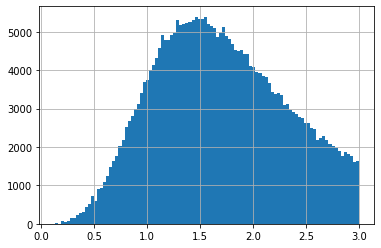

In [55]:
df_lags.volatility.hist(bins=100)

In [56]:
train_val = train_val[abs(train_val['daily_ret']) >= 2]#[abs(train_val['daily_ret']) >= 15]

In [57]:
a = train_val[train_val['ticker']== 1]
a.shape

(17, 17)

# time series cross validation

In [58]:
def classify(x):
    return x >= 1

In [59]:
from sklearn.metrics import precision_score


def time_series_cross_val_score(model, data, target, n_split=5, is_classification=False):
    tscv = TimeSeriesSplit(n_splits=n_split)
    scores = []

    for train_i, valid_i in tscv.split(data):
        train, valid = data.iloc[train_i], data.iloc[valid_i]
        X_train, y_train = train.drop(target, axis=1), train[target]
        X_valid, y_valid = valid.drop(target, axis=1), valid[target]

        if is_classification:
            y_train = y_train.map(classify)
        y_valid = y_valid.map(classify)

        model.fit(X_train, y_train)

        if is_classification:
            scoring = precision_score
            pred = model.predict_proba(X_valid)
            y_pred = np.where(pred[:, 1] > 0.65, 1, 0)
            unique, counts = np.unique(y_pred, return_counts=True)
            print(dict(zip(unique, counts)))
            print(classification_report(y_valid, y_pred))
        else:
            scoring = mean_squared_error
            y_pred = model.predict(X_valid)
            scoring = precision_score
            y_pred = np.where(y_pred > 1, 1, 0)
            unique, counts = np.unique(y_pred, return_counts=True)
            print(dict(zip(unique, counts)))
            print(classification_report(y_valid, y_pred))

        score = scoring(y_valid, y_pred)
        scores.append(score)

    return scores

In [60]:
def get_regression_report(y_pred, y_true):
    pred = np.where(y_pred > 1, 1, 0)
    unique, counts = np.unique(pred, return_counts=True)
    print(dict(zip(unique, counts)))
    y_true = y_true.map(classify)
    print(classification_report(y_true, pred))

# Regression models

In [61]:
tech_indicators = [
    'sma_above20',
    'sma_above50',
    'sma_above100',
    'sma_above200',
    'sma_10above20',
    'sma_10above50',
    'sma_10above100',
    'sma_10above200',
    'sma_cut20',
    'sma_cut50',
    'sma_cut100',
    'sma_cut200',
    'sma_10cut20',
    'sma_10cut50',
    'sma_10cut100',
    'sma_10cut200',
    'sma_cut20down',
    'sma_cut50down',
    'sma_cut100down',
    'sma_cut200down',
    'sma_10cut20down',
    'sma_10cut50down',
    'sma_10cut100down',
    'sma_10cut200down',
    'ema_above20',
    'ema_above50',
    'ema_above100',
    'ema_above200',
    'ema_10above20',
    'ema_10above50',
    'ema_10above100',
    'ema_10above200',
    'ema_cut20',
    'ema_cut50',
    'ema_cut100',
    'ema_cut200',
    'ema_10cut20',
    'ema_10cut50',
    'ema_10cut100',
    'ema_10cut200',
    'ema_cut20down',
    'ema_cut50down',
    'ema_cut100down',
    'ema_cut200down',
    'ema_10cut20down',
    'ema_10cut50down',
    'ema_10cut100down',
    'ema_10cut200down',
    'macd',
    'macd_crossover',
    'macd_crossoverdown',
    'stochastic_fast',
    'stochastic_slow',
    'stochastic_fastcutslow',
    'stochastic_fastcutslowdown',
    'stochastic_overs',
    'stochastic_overb',
    'rsi',
    'rsi_ob',
    'rsi_os',
    'bollinger_upp_dist',
    'bollinger_low_dist',
    'bollinger_ob',
    'bollinger_os'
]

In [62]:
def get_error_metrics(y_pred, y_valid):
    mae = mean_absolute_error(y_valid, y_pred)
    mape = mean_absolute_percentage_error(y_valid, y_pred)
    rmse = mean_squared_error(y_valid, y_pred)

    print("RMSE = %0.3f" % rmse)
    print("MAPE = %0.3f%%" % mape)
    print("MAE = %0.3f" % mae)

In [63]:
def show_prediction_scatter(y_pred, y_valid):
    fig, ax = plt.subplots()

    ax.set_xlabel("predicted daily returns")
    ax.set_ylabel("actural daily returns")
    ax.scatter(y_pred, y_valid)

    # y = x
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

    ax.plot(lims, [0,0], 'r-', alpha=0.75)
    ax.plot([0,0], lims, 'r-', alpha=0.75)

    ax.set_aspect('equal')

## Linear Regression

In [65]:
model = LinearRegression()
score = time_series_cross_val_score(model, train_val, "daily_ret", n_split=10)
np.mean(score)

{0: 771, 1: 121}
              precision    recall  f1-score   support

       False       0.46      0.88      0.61       409
        True       0.58      0.14      0.23       483

    accuracy                           0.48       892
   macro avg       0.52      0.51      0.42       892
weighted avg       0.53      0.48      0.40       892

{0: 864, 1: 28}
              precision    recall  f1-score   support

       False       0.29      0.97      0.45       263
        True       0.68      0.03      0.06       629

    accuracy                           0.31       892
   macro avg       0.49      0.50      0.25       892
weighted avg       0.57      0.31      0.17       892

{0: 732, 1: 160}
              precision    recall  f1-score   support

       False       0.53      0.80      0.63       481
        True       0.40      0.16      0.22       411

    accuracy                           0.50       892
   macro avg       0.46      0.48      0.43       892
weighted avg       0.47 

0.5133007970865032

In [67]:
model = LinearRegression()
dropping_cols = ['daily_ret']#'dji_ret', 'sp500_ret', 'bond5_ret', 'n225_ret', ]
model.fit(train_val.drop(dropping_cols, axis=1), train_val['daily_ret'])

LinearRegression()

In [68]:
y_pred = model.predict(test.drop(dropping_cols, axis=1))
get_regression_report(y_pred, test['daily_ret'])

{0: 296, 1: 4}
              precision    recall  f1-score   support

       False       0.76      0.99      0.86       229
        True       0.25      0.01      0.03        71

    accuracy                           0.76       300
   macro avg       0.51      0.50      0.44       300
weighted avg       0.64      0.76      0.66       300



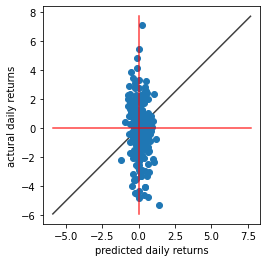

In [69]:
show_prediction_scatter(y_pred, test['daily_ret'])

In [70]:
data = {
    'prediction': list(y_pred),
    'actual': test['daily_ret'],
}

result = pd.DataFrame(data)
top10 = result.sort_values(by='prediction', ascending=False).head(10)
print(f"average 3: {top10['actual'].head(3).sum()/3}")
print(f"average 5: {top10['actual'].head(5).sum()/5}")
print(f"average 10: {top10['actual'].sum()/10}")
print(top10)

average 3: -1.217463174792055
average 5: -1.6142186680036552
average 10: -0.5736563132812877
      prediction    actual
1363    1.412451 -5.274589
1368    1.215261 -0.757573
1383    1.054550  2.379772
1382    1.042356 -2.298851
1406    0.993417 -2.119853
1387    0.979749  0.487797
1371    0.905889  0.102145
1367    0.876641  0.383877
1376    0.869373  0.845666
1403    0.856494  0.515045


## LightGBM

In [217]:
lgbm = lightgbm.LGBMRegressor(seed=seed)
score = time_series_cross_val_score(lgbm, train_val, "daily_ret", n_split=10)
np.mean(score)

0.08605939627781527

In [210]:
lgbm = lightgbm.LGBMRegressor(seed=seed)
dropping_cols = ['daily_ret']#'dji_ret', 'sp500_ret', 'bond5_ret', 'n225_ret', ]
lgbm.fit(train_val.drop(dropping_cols, axis=1), train_val['daily_ret'])
r2_score(test['daily_ret'], lgbm.predict(test.drop(dropping_cols, axis=1)))

-0.047528311455547145

In [73]:
with open('v8/lgbm.pickle', 'wb') as handle:
    pickle.dump(lgbm, handle)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

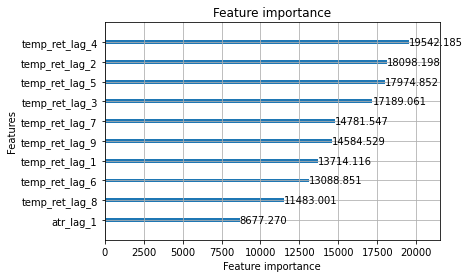

In [192]:
lightgbm.plot_importance(lgbm, max_num_features=10, importance_type='gain')

In [200]:
y_pred = lgbm.predict(test.drop(dropping_cols, axis=1))
get_regression_report(y_pred, test['daily_ret'])

{0: 225, 1: 75}
              precision    recall  f1-score   support

       False       0.73      0.75      0.74       219
        True       0.28      0.26      0.27        81

    accuracy                           0.62       300
   macro avg       0.51      0.51      0.51       300
weighted avg       0.61      0.62      0.62       300



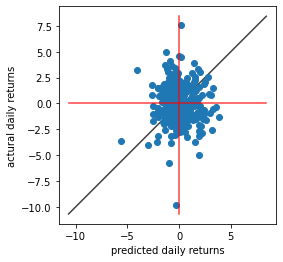

In [201]:
show_prediction_scatter(y_pred, test['daily_ret'])

In [202]:
test.head()

,ticker,sector,daily_ret,volatility,temp_ret_lag_1,temp_ret_lag_2,temp_ret_lag_3,temp_ret_lag_4,temp_ret_lag_5,temp_ret_lag_6,temp_ret_lag_7,temp_ret_lag_8,temp_ret_lag_9,adj_close_lag_1,atr_lag_1,atr_signal_lag_1,atr_signaldown_lag_1
1372,44,32,-0.352810,1.231310,-0.575608,-1.232665,3.109378,0.201969,1.664043,-0.228671,-0.570389,-0.294915,-0.158339,2187.863037,1.716964,0.0,1.0
1387,85,9,3.943377,1.901902,2.480159,5.289929,2.255639,0.219780,1.872247,-1.346801,1.107420,-1.455767,-1.103753,5040.000000,3.684587,1.0,0.0
1396,3,2,0.383142,1.119336,-1.299170,-3.045957,-1.607606,0.153113,0.971205,0.034412,0.671256,1.143649,-0.070114,27710.000000,3.594222,0.0,1.0
1393,242,8,0.384911,1.745068,-1.990521,-2.211896,1.818512,1.148361,-1.686341,0.460660,2.499074,1.955572,0.658404,2637.500000,2.905695,0.0,1.0
1405,149,30,-2.599653,1.374570,1.374570,4.703833,3.656307,-3.225806,-1.654412,-2.350814,-1.943463,-0.173310,-2.595156,5820.000000,4.192959,1.0,1.0


In [203]:
data = {
    'prediction': list(y_pred),
    'actual': test['daily_ret'],
}

lgbm_result = pd.DataFrame(data)
top10 = lgbm_result.sort_values(by='prediction', ascending=False).head(10)
print(f"average 3: {top10['actual'].head(3).sum()/3}")
print(f"average 5: {top10['actual'].head(5).sum()/5}")
print(f"average 10: {top10['actual'].sum()/10}")
print(top10)

average 3: -0.7387272948497022
average 5: -0.6641016322589532
average 10: -0.14464355591519706
      prediction    actual
1392    3.858196 -1.272830
1380    3.549615 -0.392328
1379    3.291348 -0.551024
1390    3.246753  1.495327
1405    3.217080 -2.599653
1401    3.063703  0.839866
1377    2.982655 -0.901823
1403    2.918224  0.950119
1403    2.748077  2.583893
1380    2.598684 -1.597981


# classfication

In [502]:
def classify(x):
    return x >= 3

In [7]:
y_train_c = y_train.map(classify)
y_valid_c = y_valid.map(classify)
y_test_c = y_test.map(classify)
y_train_val_c = y_train_val.map(classify)

In [722]:
def get_confusion_matrix(y_valid, y_pred):
    columns_labels = ["pred_" + str(l) for l in ["negative","positive"]]
    index_labels = ["act_" + str(l) for l in ["negative","positive"]]
    cm = pd.DataFrame(confusion_matrix(y_valid, y_pred, labels=[0,1]),
                      columns=columns_labels, index=index_labels)
    print(cm)

## Light GBM classifier

In [921]:
lgbm_clf = lightgbm.LGBMClassifier()
score = time_series_cross_val_score(lgbm_clf, train_val, "daily_ret", n_split=5, is_classification=True)
score

{0: 7366, 1: 171}
              precision    recall  f1-score   support

       False       0.47      0.98      0.63      3490
        True       0.64      0.03      0.05      4047

    accuracy                           0.47      7537
   macro avg       0.55      0.50      0.34      7537
weighted avg       0.56      0.47      0.32      7537

{0: 7054, 1: 483}
              precision    recall  f1-score   support

       False       0.66      0.94      0.78      4958
        True       0.39      0.07      0.12      2579

    accuracy                           0.64      7537
   macro avg       0.52      0.51      0.45      7537
weighted avg       0.57      0.64      0.55      7537

{0: 7286, 1: 251}
              precision    recall  f1-score   support

       False       0.67      0.97      0.79      5038
        True       0.33      0.03      0.06      2499

    accuracy                           0.66      7537
   macro avg       0.50      0.50      0.42      7537
weighted avg       0

[0.6432748538011696,
 0.38509316770186336,
 0.32669322709163345,
 0.3103448275862069,
 0.6818181818181818]

In [922]:
lgbm_clf = lightgbm.LGBMClassifier(seed=seed)
y_train_val = train_val['daily_ret'].map(classify)
y_test = test['daily_ret'].map(classify)
lgbm_clf.fit(train_val.drop('daily_ret', axis=1), y_train_val)
precision_score(y_test, lgbm_clf.predict(test.drop('daily_ret', axis=1)))

lgbm_clf_pred = lgbm_clf.predict(test.drop('daily_ret', axis=1))


In [923]:
get_confusion_matrix(y_test, lgbm_clf.predict(test.drop('daily_ret', axis=1)))

              pred_negative  pred_positive
act_negative            156             22
act_positive            116              6


In [924]:
clf_pred_df = pd.DataFrame(lgbm_clf_pred, columns=['predicted_class'])
clf_pred_df.index = lgbm_result.index
merged = pd.concat([lgbm_result, clf_pred_df], axis=1)
merged_top10 = merged[merged['predicted_class']].sort_values(by='prediction', ascending=False).head(10)
print(f"average: {merged_top10['actual'].sum()/10}")
print(merged_top10)

average: -1.1709203146224678
      prediction    actual  predicted_class
1361    4.032281 -4.842105             True
1401    2.624712  1.458886             True
1402    2.133735 -2.902318             True
1400    1.831098 -1.614435             True
1401    1.656133 -0.319646             True
1402    1.639585  2.529960             True
1403    1.553448 -4.332130             True
1357    1.525316 -4.822566             True
1381    1.507708  5.973578             True
1362    1.310514 -2.838428             True


# Tuning params

## Tuning: LightGBM

### Before tuning

In [246]:
from lightgbm import early_stopping


model = LGBMRegressor(random_state=seed, n_estimators=100)

### Find range to tune

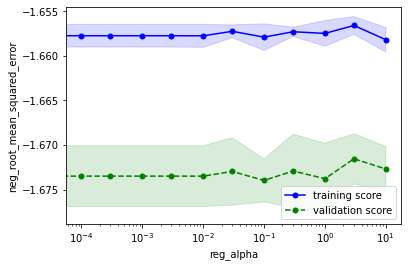

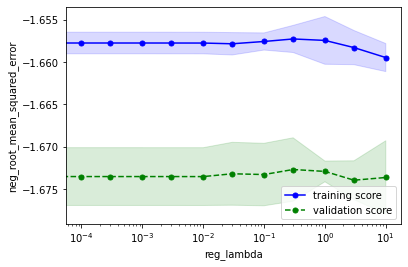

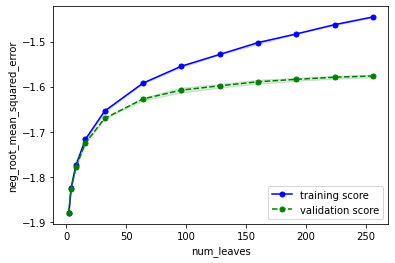

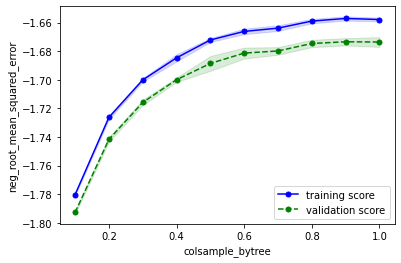

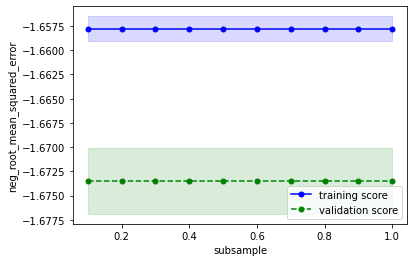

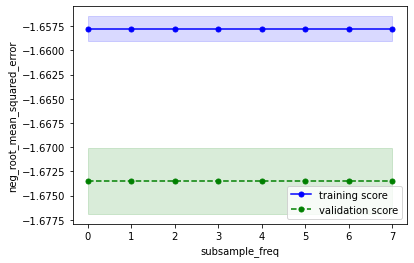

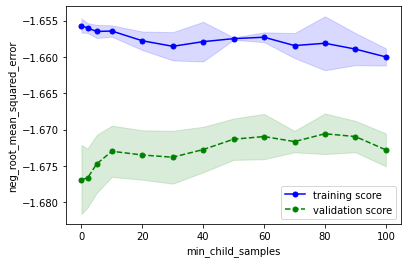

In [103]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
cv_params = {'reg_alpha': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'reg_lambda': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
             'num_leaves': [2, 4, 8, 16, 32, 64, 96, 128, 160, 192, 224, 256],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
             'min_child_samples': [0, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
             }
param_scales = {'reg_alpha': 'log',
                'reg_lambda': 'log',
                'num_leaves': 'linear',
                'colsample_bytree': 'linear',
                'subsample': 'linear',
                'subsample_freq': 'linear',
                'min_child_samples': 'linear'
                }
# 検証曲線のプロット（パラメータ毎にプロット）
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=X_train_val, y=y_train_val,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=cv, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    plt.show()

In [258]:
from sklearn.metrics import precision_score


def time_series_cross_val_score(model, data, target, n_split=10, is_classification=False):
    tscv = TimeSeriesSplit(n_splits=n_split)
    scores = []

    for train_i, valid_i in tscv.split(data):
        train, valid = data.iloc[train_i], data.iloc[valid_i]
        X_train, y_train = train.drop(target, axis=1), train[target]
        X_valid, y_valid = valid.drop(target, axis=1), valid[target]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_valid)
        compare = {
            'prediction': list(y_pred),
            'actual': y_valid,
        }

        result = pd.DataFrame(compare)
        top = result.sort_values(by='prediction', ascending=False)
        #print(f"average 3: {top['actual'].head(3).sum()/3}")
        #print(f"average 5: {top['actual'].head(5).sum()/5}")
        #print(f"average 10: {top['actual'].head(10).sum()/10}")
        ##print(top.head(10))
        top_num = int(top.shape[0] * 0.1)

        score = top['actual'].head(top_num).sum()/top_num #mean_squared_error(y_valid, y_pred)
        scores.append(score)

    return scores

In [259]:
time_series_cross_val_score(model, train_val, "daily_ret")

[0.07262953990610727,
 1.5549448117112974,
 -0.4708476871009404,
 0.43976568528793575,
 -0.09118256961897792,
 1.3302890528421911,
 -1.476427714213576,
 -0.47759932455657167,
 -1.5255174614737061,
 2.0340209858173117]

In [260]:
import optuna
start = time.time()
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 50, 250),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 0, 80)
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = time_series_cross_val_score(model, train_val, "daily_ret")
    val = np.mean(scores)
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(bayes_objective, n_trials=600)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')

[I 2022-07-26 17:08:27,559] A new study created in memory with name: no-name-70c90623-a175-4036-ad35-4496dd755a0c
[I 2022-07-26 17:08:32,899] Trial 0 finished with value: -0.04743676220571633 and parameters: {'reg_alpha': 0.13292918943162169, 'reg_lambda': 7.114476009343421, 'num_leaves': 197, 'colsample_bytree': 0.759195090518222, 'subsample': 0.4936111842654619, 'subsample_freq': 1, 'min_child_samples': 4}. Best is trial 0 with value: -0.04743676220571633.
[I 2022-07-26 17:08:36,480] Trial 1 finished with value: 0.09740107071117046 and parameters: {'reg_alpha': 3.9676050770529883, 'reg_lambda': 0.6358358856676253, 'num_leaves': 192, 'colsample_bytree': 0.41235069657748147, 'subsample': 0.9819459112971965, 'subsample_freq': 6, 'min_child_samples': 17}. Best is trial 1 with value: 0.09740107071117046.
[I 2022-07-26 17:08:38,091] Trial 2 finished with value: -0.1328073417610831 and parameters: {'reg_alpha': 0.035113563139704075, 'reg_lambda': 0.03549878832196503, 'num_leaves': 111, 'col

最適パラメータ {'reg_alpha': 1.2109958214990817, 'reg_lambda': 0.011704637152085183, 'num_leaves': 224, 'colsample_bytree': 0.4172102959287228, 'subsample': 0.5250292400727489, 'subsample_freq': 5, 'min_child_samples': 2}
スコア 0.3227670816692807
所要時間3065.099995136261秒


In [261]:
with open('v8/lgbm_params9.pickle', 'wb') as handle:
    pickle.dump(best_params, handle)

### Final LightGBM

In [262]:
#best_params = {'reg_alpha': 0.011194969057932649, 'reg_lambda': 0.1068806844643911, 'num_leaves': 209, 'colsample_bytree': 0.695914095366893, 'subsample': 0.8066393215192704, 'subsample_freq': 7, 'min_child_samples': 22}

with open('v8/lgbm_params9.pickle', 'rb') as handle:
    best_params = pickle.load(handle)

#with open('v8/lgbm_model2.pickle', 'rb') as handle:
#    model = pickle.load(handle)

In [263]:
model = LGBMRegressor(
    random_state=seed,
    n_estimators=100,
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    num_leaves=int(best_params['num_leaves']),
    colsample_bytree=best_params['colsample_bytree'],
    subsample=best_params['subsample'],
    subsample_freq=best_params['subsample_freq'],
    min_child_samples=int(best_params['min_child_samples']),
)

In [264]:
model.fit(train_val.drop('daily_ret', axis=1), train_val['daily_ret'])

LGBMRegressor(colsample_bytree=0.4172102959287228, min_child_samples=2,
              num_leaves=224, random_state=42, reg_alpha=1.2109958214990817,
              reg_lambda=0.011704637152085183, subsample=0.5250292400727489,
              subsample_freq=5)

In [265]:
scores = time_series_cross_val_score(model, train_val, "daily_ret")
np.mean(scores)

0.3227670816692807

In [266]:
with open('v8/lgbm_model9.pickle', 'wb') as handle:
    pickle.dump(model, handle)

In [267]:
y_pred = model.predict(test.drop('daily_ret', axis=1))
get_error_metrics(y_pred, test['daily_ret'])

RMSE = 4.690
MAPE = 15069288417337.689%
MAE = 1.686


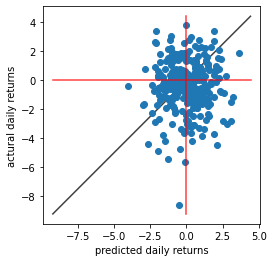

In [268]:
show_prediction_scatter(y_pred, test['daily_ret'])